In [1]:
from datetime import datetime, timezone
import os
from pathlib import Path
import sys

from dotenv import load_dotenv, find_dotenv
import pandas as pd
import pytz

In [2]:
# paths to common data locations - NOTE: to convert any path to a raw string, simply use str(path_instance)
dir_prj = Path.cwd().parent

dir_data = dir_prj/'data'

dir_raw = dir_data/'raw'
dir_ext = dir_data/'external'
dir_int = dir_data/'interim'
dir_out = dir_data/'processed'

gdb_raw = dir_raw/'raw.gdb'
gdb_int = dir_int/'interim.gdb'
gdb_out = dir_out/'processed.gdb'

# import the project package from the project package path - only necessary if you are not using a unique environemnt for this project
sys.path.append(str(dir_prj/'src'))
import river_levels

# load the "autoreload" extension so that code can change, & always reload modules so that as you change code in src, it gets loaded
%load_ext autoreload
%autoreload 2

# load environment variables from .env
load_dotenv(find_dotenv())

True

In [1]:
from river_levels import Gauge

In [5]:
gauge_id, min_flow, max_flow, metric = '14226500', 800, 1700, 'cfs'     # queets
gauge_id, min_flow, max_flow, metric = '14123500', 600, 1800, 'cfs'     # white salmon
# gauge_id, min_flow, max_flow, metric = '12134500', 700, 20000, 'cfs'    # skykomish
# gauge_id, min_flow, max_flow, metric = '12161000', 5.0, 7.0, 'height'   # robe
# gauge_id, min_flow, max_flow, metric = '07055875', 3.0, 6.0, 'height'   # richland
# gauge_id, min_flow, max_flow, metric = '07055646', 7.0, 11.0, 'height'  # hailstone
gauge_id, min_flow, max_flow, metric = '12060500', 650, 1600, 'cfs'     # sf skokomish 
# gauge_id, min_flow, max_flow, metric = '12080010', 200, 1500, 'cfs'     # deschutes oly
gauge_id, min_flow, max_flow, metric = '07091200', 400, 5000, 'cfs'     # browns canyon
gauge_id, min_flow, max_flow, metric = '11520500', 700, 8000, 'cfs'     # klamath
gauge_id, min_flow, max_flow, metric = '14372300', 1200, None, 'cfs'

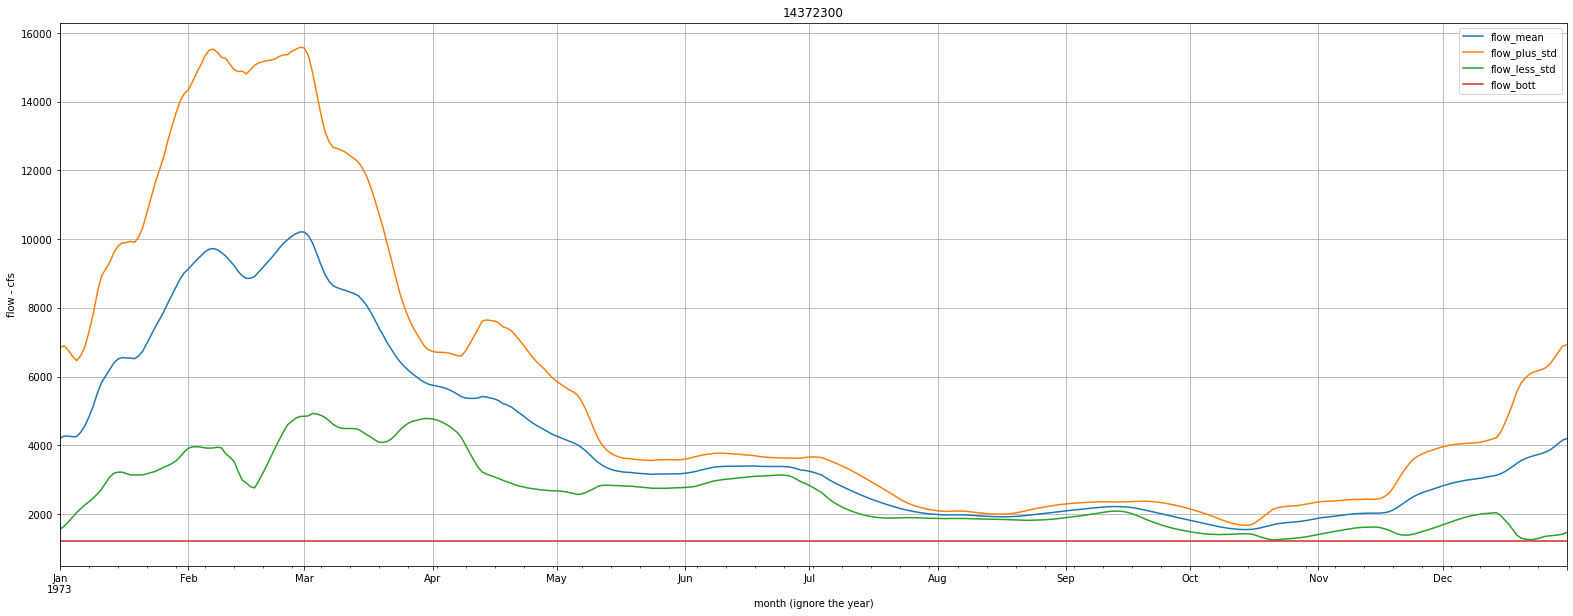

In [6]:
gauge = Gauge(gauge_id, 'usgs')
mean_df = gauge.get_rolling_mean(min=min_flow, max=max_flow)

_ = mean_df.plot(figsize=(27,10), title=gauge.id, xlabel='month (ignore the year)', ylabel=f'flow - {metric}', grid=True)

In [41]:
mean_df.reset_index().to_dict('records')

[{'timestamp': Timestamp('1973-01-01 00:00:00-0800', tz='US/Pacific'),
  'flow_mean': 1003.793941335407,
  'flow_plus_std': 1744.712572583668,
  'flow_less_std': 262.8753100871462},
 {'timestamp': Timestamp('1973-01-02 00:00:00-0800', tz='US/Pacific'),
  'flow_mean': 1019.6691267275404,
  'flow_plus_std': 1767.7149325269515,
  'flow_less_std': 271.62332092812903},
 {'timestamp': Timestamp('1973-01-03 00:00:00-0800', tz='US/Pacific'),
  'flow_mean': 1046.955591178769,
  'flow_plus_std': 1822.1583426711975,
  'flow_less_std': 271.7528396863404},
 {'timestamp': Timestamp('1973-01-04 00:00:00-0800', tz='US/Pacific'),
  'flow_mean': 1083.7279136652683,
  'flow_plus_std': 1889.1325789573555,
  'flow_less_std': 278.32324837318106},
 {'timestamp': Timestamp('1973-01-05 00:00:00-0800', tz='US/Pacific'),
  'flow_mean': 1128.3142647159873,
  'flow_plus_std': 1967.1077262267095,
  'flow_less_std': 289.5208032052652},
 {'timestamp': Timestamp('1973-01-06 00:00:00-0800', tz='US/Pacific'),
  'flow_me